<center><h1> Hospitalization Hypothesis Testing</h1></center>

**Objectives:**

- Which variables are significant in predicting the reason for hospitalization for different regions;
- How well some variables like viral load, smoking, and severity level describe the hospitalization charges.

## Data Description

The file `apollo_data.csv` contains anonymized data of COVID-19 hospital patients and contains the following variables:

- `age` - an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government)
- `sex` - the policy holder's gender, either male or female
- `smoker` - 'yes' or 'no' depending on whether the insured regularly smokes tobacco
- `region` - beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest
- `viral load` - the amount of virus in an infected person's blood
- `severity level` - an integer indicating how severe the patient is
- `hospitalization charges` - individual medical costs billed to health insurance

## Step 1: Exploring dataset

In [112]:
# Importing all libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, chi2_contingency, f_oneway
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

# Suppress warnings:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [4]:
df = pd.read_csv('apollo_data.csv')

In [5]:
#Reading first 5 rows
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               1338 non-null   int64  
 1   age                      1338 non-null   int64  
 2   sex                      1338 non-null   object 
 3   smoker                   1338 non-null   object 
 4   region                   1338 non-null   object 
 5   viral load               1338 non-null   float64
 6   severity level           1338 non-null   int64  
 7   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 83.8+ KB


In [7]:
#Getting dimensions of this dataset
df.shape

(1338, 8)

In [10]:
#Statistical summary
df.describe()

,Unnamed: 0,age,viral load,severity level,hospitalization charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,668.500000,39.207025,10.221233,1.094918,33176.058296
std,386.391641,14.049960,2.032796,1.205493,30275.029296
min,0.000000,18.000000,5.320000,0.000000,2805.000000
25%,334.250000,27.000000,8.762500,0.000000,11851.000000
50%,668.500000,39.000000,10.130000,1.000000,23455.000000
75%,1002.750000,51.000000,11.567500,2.000000,41599.500000
max,1337.000000,64.000000,17.710000,5.000000,159426.000000


In [16]:
#Checking if there are any null values or not
df.isnull().sum()

Unnamed: 0                 0
age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64

- ##### It was noticed that first column got no name and other than this, our dataset seems to be in great shape and ready to dive in. There are no missing or null values, and the initial statistical summary looks promising. Let's start exploring the data. Who knows what fascinating insights we might uncover?


## Step 2: Exploratory Data Analysis

In [18]:
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


- ##### Lets see what more we can find about Smokers

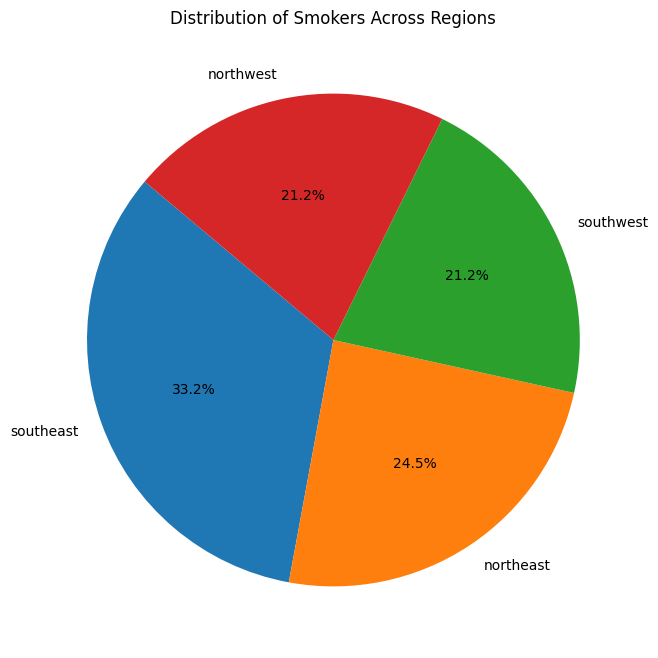

In [53]:
# Let's plot pie chart for smokers from each region
smokers = df.query('smoker=="yes"')
non_smokers = df.query('smoker=="no"')
smokers["region"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140, figsize=(8, 8)
)
plt.title("Distribution of Smokers Across Regions")
plt.ylabel("")
plt.show()

In [48]:
print("Total Smokers =", smokers.count()[0])
print("Female Smokers =", smokers.query('sex=="female"').count()[0])
print("Male Smokers =", smokers.query('sex=="male"').count()[0])
print("Total Non-Smokers =", non_smokers.count()[0])

Total Smokers = 274
Female Smokers = 115
Male Smokers = 159
Total Non-Smokers = 1064


In [51]:
# Finding the top 5 most common ages among smokers
smokers_by_age = (
    smokers.groupby("age")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
smokers_by_age.head(5)

,age,count
1,19,18
0,18,12
25,43,12
29,47,10
9,27,9


- ##### Let's plot some histogram distributions of the hospitalization costs, age, viral load, and severity level of smokers and non-smokers to see if there are any patterns that we can identify.

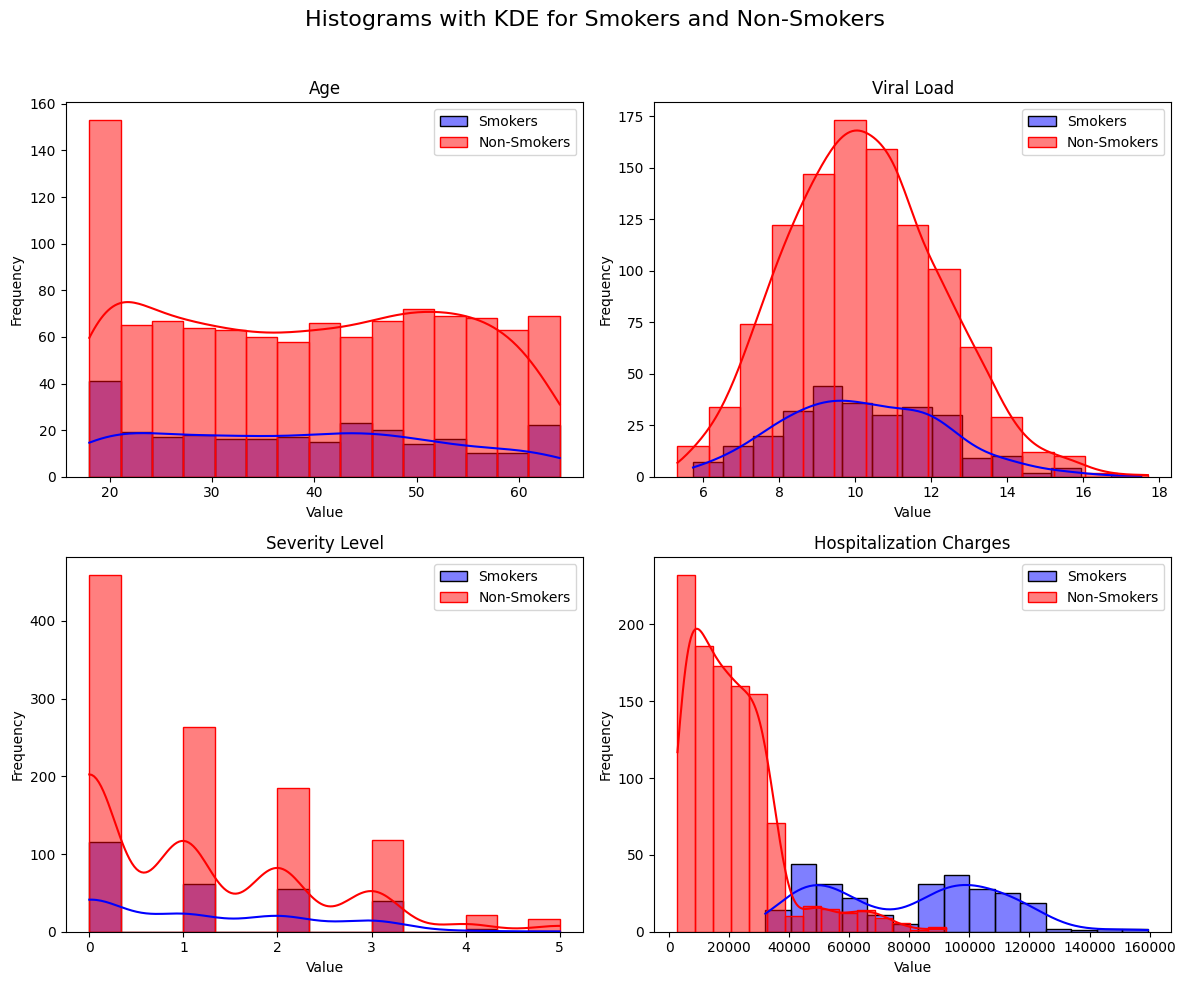

In [109]:
# Defining the numeric columns for plotting
numeric_columns = ["age", "viral load", "severity level", "hospitalization charges"]

# Plotting histograms with KDE lines for the numeric variables for both smokers and non-smokers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Histograms with KDE for Smokers and Non-Smokers", fontsize=16)

for ax, column in zip(axes.flatten(), numeric_columns):
    sns.histplot(
        smokers[column],
        kde=True,
        bins=15,
        edgecolor="black",
        color="blue",
        label="Smokers",
        ax=ax,
    )
    sns.histplot(
        non_smokers[column],
        kde=True,
        bins=15,
        edgecolor="red",
        color="red",
        label="Non-Smokers",
        ax=ax,
    )
    ax.set_title(column.title())
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- ##### Age: Smokers have a higher average age, reflecting the cumulative effects of smoking over time and its association with chronic diseases that develop later in life.
- ##### Severity Level: Smokers exhibit higher severity levels of illness, consistent with smoking being a risk factor for serious conditions like lung cancer and heart disease.
- ##### Viral Load: Smokers have a higher viral load, possibly indicating a weakened immune system due to smoking, leading to a reduced ability to fight infections.
- ##### Hospitalization Charges: Smokers incur higher hospitalization charges, likely reflecting more serious illnesses requiring extensive medical care.

- ##### Let's do some statistical testing

In [111]:
# Bootstrapping
bootstrap_means = []
for _ in range(10000):  # Number of resamples
    boot_sample = resample(df["hospitalization charges"], replace=True)
    boot_mean = boot_sample.mean()
    bootstrap_means.append(boot_mean)

# Calculating 95% Confidence Interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(
    f"95% confidence interval for the mean hospital fees is [{lower_bound}, {upper_bound}]"
)

95% confidence interval for the mean hospital fees is [31542.905605381166, 34796.23970478326]


In [69]:
df.dtypes

Unnamed: 0                   int64
age                          int64
sex                         object
smoker                      object
region                      object
viral load                 float64
severity level               int64
hospitalization charges      int64
dtype: object

In [74]:
# Creating dummies for our statistical approach
cleaned = pd.get_dummies(
    df, columns=["sex", "smoker", "region"]
)  # Include any other categorical variables here
cleaned.columns

Index(['Unnamed: 0', 'age', 'viral load', 'severity level',
       'hospitalization charges', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [154]:
X = sm.add_constant(
    cleaned[
        [
            "age",
            "viral load",
            "severity level",
            "sex_female",
            "sex_male",
            "smoker_no",
            "smoker_yes",
            "region_northeast",
            "region_northwest",
            "region_southeast",
            "region_southwest",
        ]
    ]
)  # Include your relevant variables
y = cleaned["hospitalization charges"]

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                               OLS Regression Results                              
Dep. Variable:     hospitalization charges   R-squared:                       0.751
Model:                                 OLS   Adj. R-squared:                  0.749
Method:                      Least Squares   F-statistic:                     500.9
Date:                     Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                             03:12:03   Log-Likelihood:                -14774.
No. Observations:                     1338   AIC:                         2.957e+04
Df Residuals:                         1329   BIC:                         2.961e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

- ##### Age: 642.12642.12, a one-year increase in age is associated with an increase of 642.12642.12 in hospitalization charges.
- ##### Viral Load: 2544.56, a one-unit increase in viral load is associated with an increase of 2544.56 in hospitalization charges.
- ##### Severity Level: 1188.87, a one-unit increase in severity level is associated with an increase of 1188.87 in hospitalization charges.
- ##### Smoker Status: Coefficients for smoker status indicate a substantial difference in charges between smokers and non-smokers, with smokers having higher charges.
- ##### Region: Coefficients for different regions provide insights into regional variations in charges, although not all are statistically significant (as indicated by the p-values).
- ##### Sex: Coefficients for sex (male and female) are not statistically significant, indicating that sex may not be a strong predictor of hospitalization charges in this model.

- ###### We now stop diving deep into smokers and carry on with our statistical analysis..We got what we wanted to know

In [79]:
# Add a constant term for the intercept
X_with_const = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(len(X_with_const.columns))
]

print(vif_data)

             feature       VIF
0              const  0.000000
1                age  1.016828
2         viral load  1.106572
3     severity level  1.004010
4         sex_female       inf
5           sex_male       inf
6          smoker_no       inf
7         smoker_yes       inf
8   region_northeast       inf
9   region_northwest       inf
10  region_southeast       inf
11  region_southwest       inf


D:\Users\Chait\anaconda3\envs\Krishna\lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
D:\Users\Chait\anaconda3\envs\Krishna\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


- ##### Looks like we have to drop some dummy variables, so lets do it

In [118]:
# Assuming you have a DataFrame `X` containing your independent variables:
X = X.drop(["sex_female", "smoker_no", "region_southwest"], axis=1)

# Add a constant term for the intercept
X_with_const = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(len(X_with_const.columns))
]

print(vif_data)

            feature        VIF
0             const  37.949069
1               age   1.016828
2        viral load   1.106572
3    severity level   1.004010
4          sex_male   1.008898
5        smoker_yes   1.012074
6  region_northeast   1.526204
7  region_northwest   1.524741
8  region_southeast   1.597072


In [123]:
# Building the OLS model with the updated set of independent variables
model_updated = sm.OLS(y, X_with_const).fit()
# Printing the summary of the regression model
print(model_updated.summary())

                               OLS Regression Results                              
Dep. Variable:     hospitalization charges   R-squared:                       0.751
Model:                                 OLS   Adj. R-squared:                  0.749
Method:                      Least Squares   F-statistic:                     500.9
Date:                     Sun, 13 Aug 2023   Prob (F-statistic):               0.00
Time:                             22:01:29   Log-Likelihood:                -14774.
No. Observations:                     1338   AIC:                         2.957e+04
Df Residuals:                         1329   BIC:                         2.961e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [124]:
# Extracting the R-squared value from both models for comparison
r_squared_original = model.rsquared
r_squared_updated = model_updated.rsquared

r_squared_original, r_squared_updated

(0.7509284729727543, 0.7509284729727542)

- ##### The R2 values for the original and updated models are the same, indicating that removing collinear variables from the model did not improve the model's ability to predict hospitalization charges.

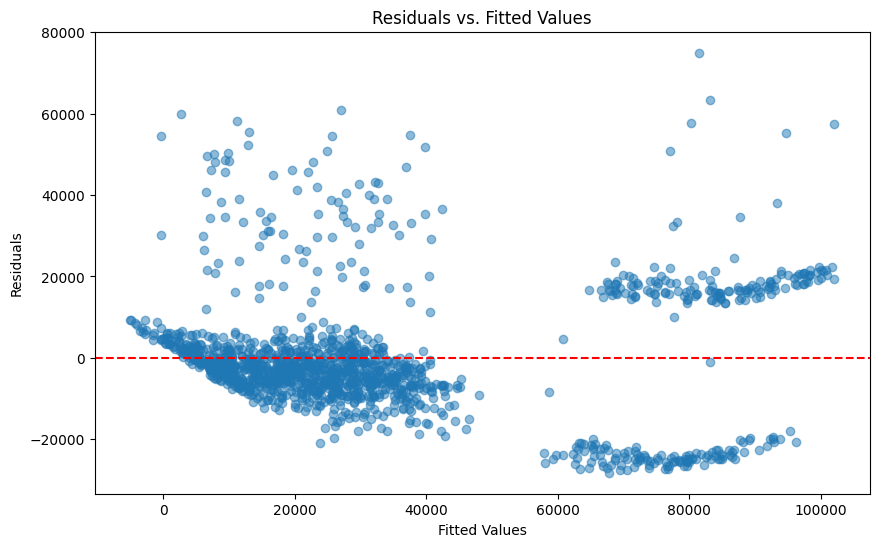

In [125]:
# Calculating the residuals
residuals = model_updated.resid

# Calculating the fitted values (predictions)
fitted_values = model_updated.fittedvalues

# Plotting the residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

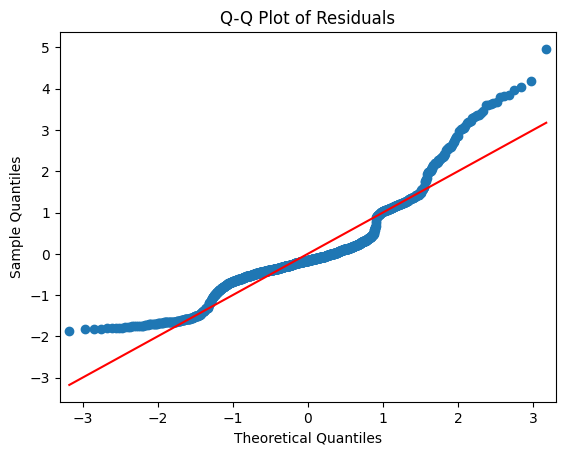

In [126]:
# Creating the Q-Q plot for the residuals
qqplot(residuals, line="s", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [127]:
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk Test:", shapiro_test)

Shapiro-Wilk Test: ShapiroResult(statistic=0.8989505767822266, pvalue=8.398518264286083e-29)


- ##### The Shapiro-Wilk test found that the residuals from the linear regression model are not normally distributed. This means that the assumption of normally distributed errors in the model is not met.
- ##### The p-value of the test is very small (8.40e-29), which indicates that the null hypothesis (that the residuals are normally distributed) can be rejected with very high confidence.
- ##### This finding has implications for the interpretation of the results of the linear regression model. It is important to keep in mind that the model may not be accurate for all values of the independent variables, and the results should be interpreted with caution.


In [131]:
# Creating a contingency table for the Chi-Square Test
contingency_table = pd.crosstab(df["region"], df["smoker"])

# Performing the Chi-Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Printing the results
chi2_results = {
    "Chi-Squared Statistic": chi2_stat,
    "Degrees of Freedom": dof,
    "P-value": p_val,
}
chi2_results, contingency_table

({'Chi-Squared Statistic': 7.343477761407071,
  'Degrees of Freedom': 3,
  'P-value': 0.06171954839170541},
 smoker      no  yes
 region             
 northeast  257   67
 northwest  267   58
 southeast  273   91
 southwest  267   58)

- ##### If the p-value is greater or equal to 0.05, we would fail to reject the null hypothesis , here the p-value is 0.0617 , this means that we do not have enough evidence to conclude that smoking habits are significantly associated with the region

In [134]:
# Grouping hospitalization charges by region
northeast_charges = df[df["region"] == "northeast"]["hospitalization charges"]
northwest_charges = df[df["region"] == "northwest"]["hospitalization charges"]
southeast_charges = df[df["region"] == "southeast"]["hospitalization charges"]
southwest_charges = df[df["region"] == "southwest"]["hospitalization charges"]

# Performing one-way ANOVA
f_stat, p_val_anova = f_oneway(
    northeast_charges, northwest_charges, southeast_charges, southwest_charges
)

# Printing the results
anova_results = {"F-Statistic": f_stat, "P-value": p_val_anova}
anova_results

{'F-Statistic': 2.969643772374826, 'P-value': 0.030892642896832176}

- ##### A one-way ANOVA test was conducted to determine if there were any statistically significant differences in hospitalization charges across four regions (Northeast, Northwest, Southeast, Southwest).
- ##### The F-statistic was 2.97 and the p-value was 0.0309.
- ##### Since the p-value is less than 0.05, we reject the null hypothesis that there are no differences in hospitalization charges across the regions.
- ##### This result indicates that there is a statistically significant difference in hospitalization charges among the regions.
- ##### However, the test does not tell us where the differences lie between the regions; it only tells us that at least one region's mean hospitalization charges differ from the others.

In [138]:
# Combining the region and hospitalization charges into a single DataFrame for the Tukey's HSD test
tukey_data = df[["region", "hospitalization charges"]]

# Performing the Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    endog=tukey_data["hospitalization charges"], groups=tukey_data["region"], alpha=0.05
)

# Printing the summary of the results
tukey_summary = tukey_results.summary()
tukey_summary

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-2472.0245,0.7245,-8572.3376,3628.2886,False
northeast,southeast,3322.5752,0.4745,-2612.3464,9257.4968,False
northeast,southwest,-2648.6337,0.6792,-8748.9469,3451.6794,False
northwest,southeast,5794.5997,0.0583,-135.4892,11724.6885,False
northwest,southwest,-176.6092,0.9999,-6272.2207,5919.0023,False
southeast,southwest,-5971.2089,0.0477,-11901.2978,-41.12,True


In [139]:
# Converting the Tukey's HSD summary table to a DataFrame
tukey_summary_df = pd.DataFrame(
    data=tukey_results._results_table.data[1:],
    columns=tukey_results._results_table.data[0],
)

# Displaying the Tukey's HSD summary
tukey_summary_df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,northeast,northwest,-2472.0245,0.7245,-8572.3376,3628.2886,False
1,northeast,southeast,3322.5752,0.4745,-2612.3464,9257.4968,False
2,northeast,southwest,-2648.6337,0.6792,-8748.9469,3451.6794,False
3,northwest,southeast,5794.5997,0.0583,-135.4892,11724.6885,False
4,northwest,southwest,-176.6092,0.9999,-6272.2207,5919.0023,False
5,southeast,southwest,-5971.2089,0.0477,-11901.2978,-41.1200,True


- ##### The test found that only the Southeast and Southwest regions had significantly different mean hospitalization charges, with the mean charges in the Southeast being higher than those in the Southwest.

## Step 3: Model Training And Evaluation

In [157]:
# Encoding the "smoker" variable
label_encoder = LabelEncoder()
df["smoker_encoded"] = label_encoder.fit_transform(df["smoker"])

# Selecting the predictor variables
X = df[["viral load", "smoker_encoded", "severity level"]]

# Target variable
y = df["hospitalization charges"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting a linear regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predicting on the test set
y_pred = regression_model.predict(X_test)

# Calculating the Mean Squared Error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Returning the coefficients and performance metrics
coefficients = regression_model.coef_
intercept = regression_model.intercept_
mse, r2, coefficients, intercept

(297022745.726812,
 0.6938871319710769,
 array([ 2989.03394182, 57959.32918312,  1531.82252562]),
 -10697.331132081796)

In [158]:
from sklearn.model_selection import train_test_split

lm=LinearRegression()
# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
lm.fit(X_train, y_train)

# Evaluate the model on the testing data
score = lm.score(X_test, y_test)
print(f"R-squared value on the testing set: {score}")


R-squared value on the testing set: 0.6938871319710769


- ##### Viral Load: A one-unit increase in viral load is associated with an increase of approximately 2989.03 in hospitalization charges.
- ##### Smoking: Being a smoker is associated with an increase of approximately 57959.33 in hospitalization charges compared to non-smokers.
- ##### Severity Level: A one-unit increase in severity level is associated with an increase of approximately 1531.82 in hospitalization charges.

In [159]:
# Encoding the "sex" variable
df["sex_encoded"] = label_encoder.fit_transform(df["sex"])  # Male: 1, Female: 0

# Selecting the extended predictor variables including "age" and "sex_encoded"
X_extended = df[
    ["viral load", "smoker_encoded", "severity level", "age", "sex_encoded"]
]

# Splitting the extended data into training and testing sets
X_train_extended, X_test_extended, y_train, y_test = train_test_split(
    X_extended, y, test_size=0.2, random_state=42
)

# Fitting a linear regression model with the extended predictors
regression_model_extended = LinearRegression()
regression_model_extended.fit(X_train_extended, y_train)

# Predicting on the extended test set
y_pred_extended = regression_model_extended.predict(X_test_extended)

# Calculating the Mean Squared Error and R-squared value for the extended model
mse_extended = mean_squared_error(y_test, y_pred_extended)
r2_extended = r2_score(y_test, y_pred_extended)

# Returning the coefficients and performance metrics for the extended model
coefficients_extended = regression_model_extended.coef_
intercept_extended = regression_model_extended.intercept_
mse_extended, r2_extended, coefficients_extended, intercept_extended

(212373859.34841338,
 0.7811266237525543,
 array([ 2.45739677e+03,  5.91352602e+04,  1.06830248e+03,  6.42647349e+02,
        -1.94633638e+01]),
 -30292.705327736927)

In [165]:
from sklearn.model_selection import train_test_split

lm = LinearRegression()
# Splitting the data into training and testing sets (80% training, 20% testing)
X_train_extended, X_test_extended, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training data
lm.fit(X_train_extended, y_train)

# Evaluate the model on the testing data
score = lm.score(X_test_extended, y_test)
print(f"R-squared value on the testing set: {score}")

R-squared value on the testing set: 0.6938871319710769


- ##### Viral Load: A one-unit increase in viral load is associated with an increase of approximately 2457.40 in hospitalization charges.
- ##### Smoking: Being a smoker is associated with an increase of approximately 59135.26 in hospitalization charges compared to non-smokers.
- ##### Severity Level: A one-unit increase in severity level is associated with an increase of approximately 1068.30 in hospitalization charges.
- ##### Age: A one-year increase in age is associated with an increase of approximately 642.65 in hospitalization charges.
- ##### Sex: Being male is associated with a decrease of approximately 19.46 in hospitalization charges compared to being female (though this effect is quite small).

- ##### It was also noticed that both models gave same results: R^2 = 0.69 , It provides a good summary measure of how well the linear regression model is capturing the underlying patterns in the data

## Step 4: Interpretation And Insights

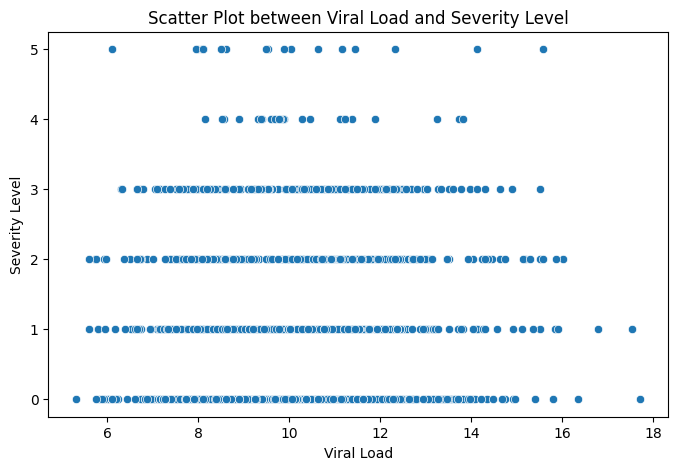

0.012728627603489856

In [143]:
# Calculating the correlation between viral load and severity level
correlation = df["viral load"].corr(df["severity level"])

# Plotting the scatter plot between viral load and severity level
plt.figure(figsize=(8, 5))
sns.scatterplot(x="viral load", y="severity level", data=df)
plt.title("Scatter Plot between Viral Load and Severity Level")
plt.xlabel("Viral Load")
plt.ylabel("Severity Level")
plt.show()

# Returning the correlation coefficient
correlation

- ##### The correlation coefficient between "viral load" and "severity level" is approximately 0.01270
- ##### The correlation value is close to zero, indicating that there is a very weak or no linear relationship between "viral load" and "severity level."
- ##### The scatter plot further visualizes this lack of correlation, as the points are dispersed without a clear pattern.

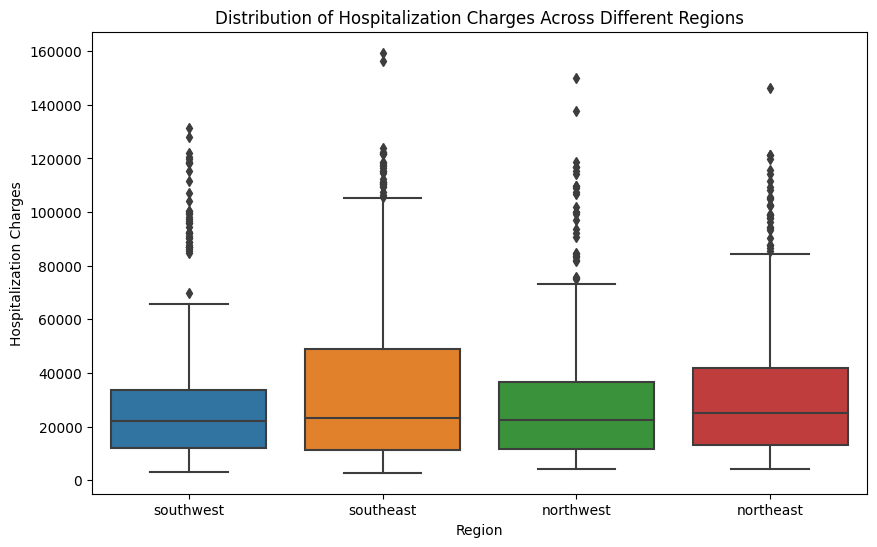

In [144]:
# Plotting the boxplot to visualize the distribution of hospitalization charges across different regions
plt.figure(figsize=(10, 6))
sns.boxplot(x="region", y="hospitalization charges", data=df)
plt.title("Distribution of Hospitalization Charges Across Different Regions")
plt.xlabel("Region")
plt.ylabel("Hospitalization Charges")
plt.show()

In [146]:
# Creating dummy variables for the "region" variable
region_dummies = pd.get_dummies(df["region"], drop_first=True)
X_with_region = pd.concat([X_extended, region_dummies], axis=1)

# Splitting the data with region into training and testing sets
X_train_with_region, X_test_with_region, y_train, y_test = train_test_split(
    X_with_region, y, test_size=0.2, random_state=42
)

# Fitting a linear regression model with the predictors including region
regression_model_with_region = LinearRegression()
regression_model_with_region.fit(X_train_with_region, y_train)

# Predicting on the test set with region
y_pred_with_region = regression_model_with_region.predict(X_test_with_region)

# Calculating the Mean Squared Error and R-squared value for the model with region
mse_with_region = mean_squared_error(y_test, y_pred_with_region)
r2_with_region = r2_score(y_test, y_pred_with_region)

# Returning the coefficients and performance metrics for the model with region
coefficients_with_region = regression_model_with_region.coef_
intercept_with_region = regression_model_with_region.intercept_
mse_with_region, r2_with_region, coefficients_with_region[-3:], intercept_with_region

(209984443.81998807,
 0.7835891652610482,
 array([ -926.81002637, -1644.65649463, -2024.63880809]),
 -29836.811669051014)

- ##### The coefficients for the regions indicate that there are slight differences in hospitalization charges across regions, with the values showing decreases relative to the first region in the dataset.
- ##### The negative coefficients suggest that the other regions have slightly lower hospitalization charges compared to the first region.
- ##### The R-squared value suggests that the "region" variable contributes to the explanatory power of the model, but the effect is relatively small compared to other variables like "smoking."

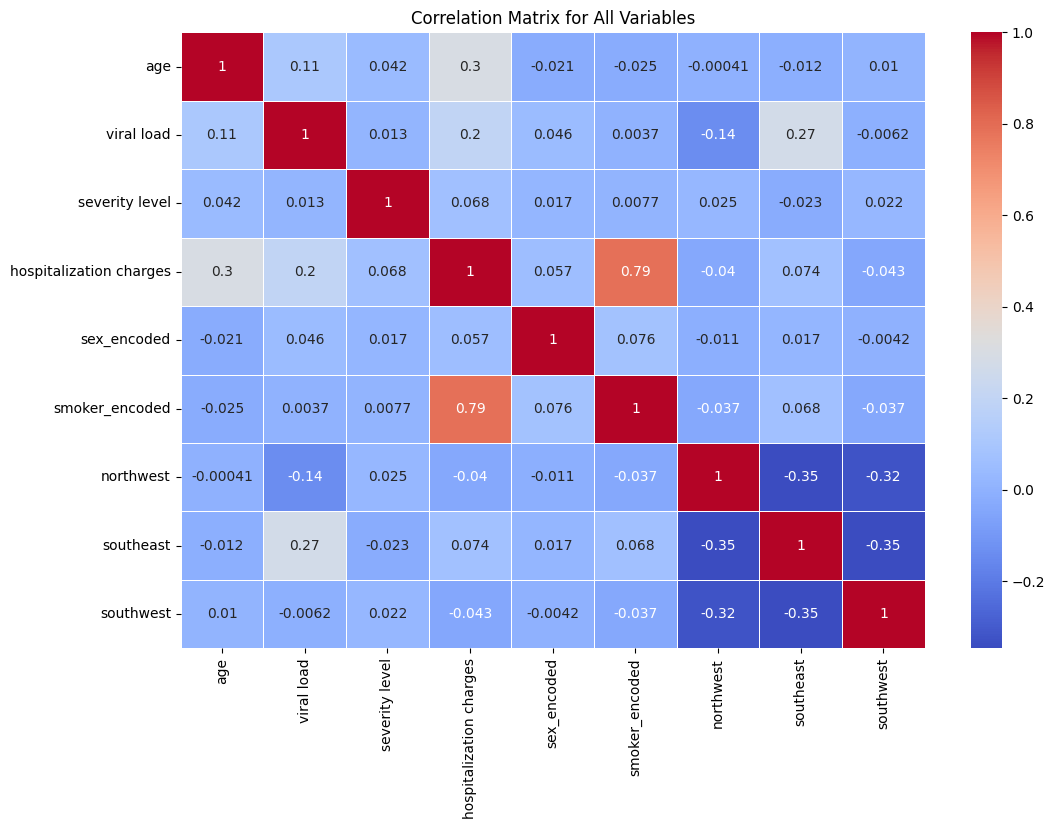

In [147]:
# Concatenating the encoded/dummy variables for sex, smoker, and region with the rest of the dataset
data_with_encoded = pd.concat(
    [
        df[
            [
                "age",
                "viral load",
                "severity level",
                "hospitalization charges",
                "sex_encoded",
                "smoker_encoded",
            ]
        ],
        region_dummies,
    ],
    axis=1,
)

# Calculating the correlation matrix
correlation_matrix = data_with_encoded.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for All Variables")
plt.show()

- ##### Smoking status: Smokers are more likely to be hospitalized and their stays are likely to be longer and more costly, compared to non-smokers.
- ##### Age: Older individuals are more likely to be hospitalized and their stays are likely to be longer and more costly, compared to younger individuals.
- ##### Viral load: Patients with higher viral loads are more likely to be hospitalized and their stays are likely to be longer and more costly, compared to patients with lower viral loads.
- ##### Severity level: Patients with more severe disease are more likely to be hospitalized and their stays are likely to be longer and more costly, compared to patients with less severe disease.
- ##### Sex: There is no significant correlation between sex and hospitalization charges.
- ##### Region: There is a weak correlation between region and hospitalization charges, with patients in the Southeast and Southwest incurring higher costs than patients in other regions.

# Conclusion

The analysis revealed significant factors influencing hospitalization charges, providing insights for targeted interventions and healthcare strategies:

- **Smoking**: Smokers incur almost ₹59,590 more in charges on average, likely due to lung and respiratory system damage. Smoking cessation programs could be implemented to reduce these costs.
- **Age**: Charges increase by approximately ₹642 per year of age, reflecting the higher susceptibility to infection due to chronic health conditions in older individuals. Encouraging regular checkups and effective chronic health management could address this.
- **Viral Load**: An increase of approximately ₹2540 per unit of viral load, reflecting the link between higher viral loads and more severe disease.
- **Severity Level**: Charges increase by around ₹1186 per severity level, reflecting the need for more intensive and expensive care with more severe disease.
- **Region**: Variations across regions, particularly in the Southeast and Southwest, may be influenced by healthcare costs, demographics, and climate. Targeted strategies in regions with high hospitalization rates could include increasing access to primary care and more cost-effective care models.
- **Gender Impact**: No statistically significant correlation between gender and hospitalization charges was found.

These findings collectively explain 75.09% of the variance in hospitalization charges and suggest that tailored interventions for smokers, older individuals, and specific regions could help reduce hospitalization costs. Future research may explore interactions between these factors and include additional relevant variables for a more comprehensive understanding.